### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
%run 00-start-server.ipynb
cursor = connect_to_server()

Found existing installation: evadb 0.0.9
Uninstalling evadb-0.0.9:
  Successfully uninstalled evadb-0.0.9
Note: you may need to restart the kernel to use updated packages.
  Using cached evadb-0.0.9-py3-none-any.whl (408 kB)
Note: you may need to restart the kernel to use updated packages.


sh: 1: kill: Usage: kill [-s sigspec | -signum | -sigspec] [pid | job]... or
kill -l [exitstatus]


rm: cannot remove 'nohup.out': No such file or directory
cat: nohup.out: No such file or directory


22/09/12 10:47:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
09-12-2022 10:47:21 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.
09-12-2022 10:47:21 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Array_Count already exists, nothing added.
09-12-2022 10:47:21 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Crop already exists, nothing added.
09-12-2022 10:47:21 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF DummyObjectDetector already exists, nothing added.
09-12-2022 10:47:21 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF DummyMultiObjectDetector already 

### Load the surveillance videos for analysis

In [3]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD FILE "../data/ua_detrac/ua_detrac.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.014213903807103634
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: ../data/...
@batch_size: 1
@identifier_column: None
@query_time: 0.021194487810134888


09-12-2022 10:47:40 ERROR [opencv_storage_engine:opencv_storage_engine.py:drop:0057] Failed to drop the video table [Errno 2] No such file or directory: '/home/jarulraj3/.eva/eva_datasets/b85f1d66f1f3bafe2b2a31c17fc8946b'
Traceback (most recent call last):
  File "/nethome/jarulraj3/eva/test_evadb/lib/python3.8/site-packages/eva/storage/opencv_storage_engine.py", line 55, in drop
    shutil.rmtree(str(dir_path))
  File "/usr/lib/python3.8/shutil.py", line 709, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.8/shutil.py", line 707, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/home/jarulraj3/.eva/eva_datasets/b85f1d66f1f3bafe2b2a31c17fc8946b'
09-12-2022 10:47:40 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None


### Visualize Video

In [4]:
from ipywidgets import Video
Video.from_file("../data/ua_detrac/ua_detrac.mp4", embed=True)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

### Optional - Register FasterRCNN (object detection) model into EVA 

#### Syntax
  
  `CREATE UDF [ IF NOT EXISTS ] <name> 
      INPUT  ( [ <arg_name> <arg_data_type> ] [ , ... ] )
      OUTPUT ( [ <result_name> <result_data_type> ] [ , ... ] )
      TYPE  <udf_type_name>
      IMPL  '<path_to_implementation>'`

#### Required Parameters
`<name>` - specifies the unique identifier for the UDF.

`[ <arg_name> <arg_data_type> ] [ , ... ]` - specifies the name and data type of the udf input arguments. Name is kept for consistency (ignored by eva right now), arguments data type is required. `ANYDIM` means the shape is inferred at runtime.

`[ <result_name> <result_data_type> ] [ , ... ]` - specifies the name and data type of the udf output arguments. 
Users can access a specific output of the UDF similar to access a column of a table. Eg. `<name>.<result_name>` 

`<udf_type_name>` - specifies the identifier for the type of the UDF. UDFs of the same type are assumed to be interchangeable. They should all have identical input and output arguments. For example, object classification can be one type. 

`<path_to_implementation>` - specifies the path to the implementation class for the UDF

In [5]:
cursor.execute("""CREATE UDF IF NOT EXISTS FastRCNNObjectDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'src/udfs/fastrcnn_object_detector.py';
      """)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF FastRCNNObjectDetector already exists, not...
@batch_size: 1
@identifier_column: None
@query_time: 0.012709709350019693


09-12-2022 10:48:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.


### Run Object detector on the video

In [6]:
cursor.execute("""SELECT id, FastRCNNObjectDetector(data) 
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response = cursor.fetch_all()

/nethome/jarulraj3/eva/test_evadb/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Visualize output of Object detector on the video

In [7]:
print(response)

@status: 0
@batch: Batch Object:
@dataframe:     objectdetectionvideos.id  \
0                          0   
1                          1   
2                          2   
3                          3   
4                          4   
5                          5   
6                          6   
7                          7   
8                          8   
9                          9   
10                        10   
11                        11   
12                        12   
13                        13   
14                        14   
15                        15   
16                        16   
17                        17   
18                        18   
19                        19   

                        fastrcnnobjectdetector.labels  \
0   [person, car, car, car, car, car, car, car, ca...   
1   [person, car, car, car, car, car, car, car, ca...   
2   [person, car, car, car, car, car, car, car, ca...   
3   [person, car, car, car, car, car, car, car, ca... 

In [33]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(242,98,121)
    thickness=3

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['fastrcnnobjectdetector.bboxes', 'fastrcnnobjectdetector.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1 = bbox[0]
                x2, y2 = bbox[1]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness-1) 
                # frame label
                cv2.putText(img, 'Frame ID: ' + str(frame_id), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness+1) 
            video.write(img)

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(img)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

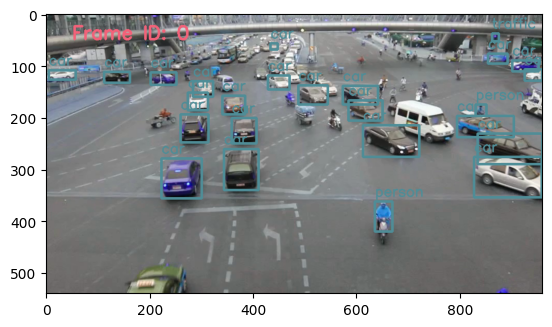

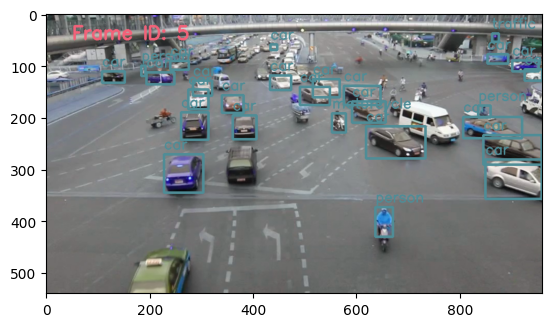

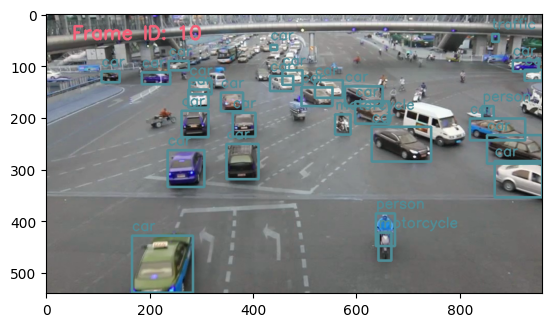

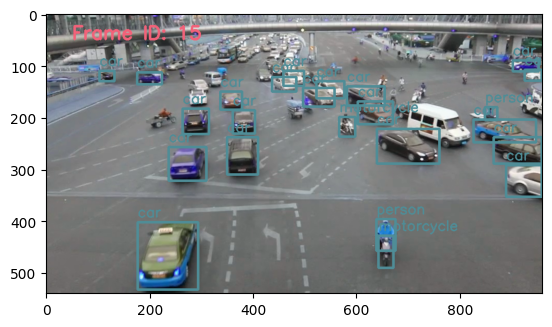

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x07\xe9\xe8...')

In [34]:
from ipywidgets import Video, Image
input_path = '../data/ua_detrac/ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response.batch.frames
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)